In [1]:
#from future import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
import pandas as pandas

# set parameters:
max_features = 91011
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

print('Loading data...')
dataframe = pandas.read_csv("C:\\Users\\Cv\\Desktop\\Netdata_labeled.csv", engine='python', header=None)
dataset = dataframe
X = dataset.iloc[1:,:9].values.astype(list)
X = X.astype(int)
Y = dataset.iloc[1:,9].values.astype(int)

df = pandas.read_csv("C:\\Users\\Cv\\Desktop\\Test_data_labeled.csv", engine='python', header=None)
x_test = df.iloc[1:,:9].values.astype(list)
x_test = x_test.astype(int)
y_test = df.iloc[1:,9].values.astype(int)


Using TensorFlow backend.


Loading data...


In [2]:
import keras
x_train = X
y_train = Y
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()


# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
#model.add((LSTM(25)))
# we use max pooling:
model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.callbacks import CSVLogger,BaseLogger
call = BaseLogger(stateful_metrics= None)
csv_logger = CSVLogger('callbacks.csv', append=True, separator=';')
from keras.callbacks import ProgbarLogger
call1 = ProgbarLogger(count_mode='samples', stateful_metrics=None)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
class AccHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('acc'))
        
        
        
History = LossHistory()
History1 = AccHistory()

model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test), verbose=1, callbacks=[call,csv_logger,call1,History,History1])



Pad sequences (samples x time)
x_train shape: (91010, 400)
x_test shape: (3505, 400)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 91010 samples, validate on 3505 samples
Epoch 1/2
Epoch 1/2
91010/91010 [==============================] - 467s 5ms/step - loss: 0.2934 - acc: 0.8193 - val_loss: 2.1052 - val_acc: 0.0496
Epoch 2/2
Epoch 2/2
91010/91010 [==============================] - 464s 5ms/step - loss: 0.1087 - acc: 0.9585 - val_loss: 4.3478 - val_acc: 0.1338


In [3]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [4]:
from keras.models import model_from_json
import numpy
import os
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [15]:


from sklearn.metrics import roc_curve


y_pred_keras = model.predict(x_test).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_cnn = auc(fpr_cnn, tpr_cnn)

from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba( sequence.pad_sequences(x_test, maxlen=maxlen))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

ValueError: bad input shape (137175, 2)

In [7]:
import pandas as pandas
from keras.preprocessing import sequence
df = pandas.read_csv("C:\\Users\\Cv\\Desktop\\Testing\\Combined45403.csv", engine='python', header=None)
x_test = df.iloc[1:,:9].values.astype(list)
x_test = x_test.astype(int)
x_test = sequence.pad_sequences(x_test, maxlen=400)
y_test = df.iloc[1:,9].values.astype(int)

loaded_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

14010/14010 [==============================] - 29s 2ms/step
acc: 11.42%


In [19]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
df = pd.read_csv("C:\\Users\\Cv\\Desktop\\Netdata.csv")
df = df.astype(float)
df[df < 0] = 0
df.apply(pd.to_numeric, errors='coerce')
df.to_csv('C:\\Users\Cv\\Desktop\\Netdata_labeled.csv') 

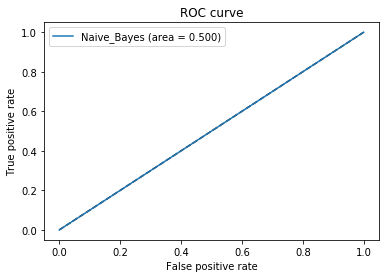

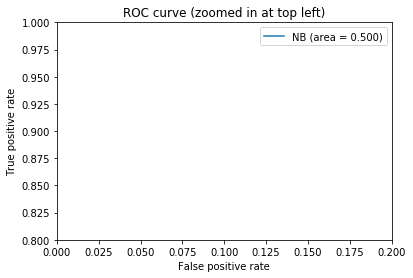

In [10]:
import pandas as pd
import pandas as pandas
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

#Create a Gaussian Classifier
df = pd.read_csv("C:\\Users\\Cv\\Desktop\\Asli_21-04-20_data_labeled.csv")
X = df.iloc[1:,:9]
y = df.iloc[1:,9]
model = GaussianNB()
model.fit(X, y)

df = pandas.read_csv("C:\\Users\\Cv\\Desktop\\Asli_Net_Comb_PlusB_labeled.csv", engine='python', header=None)
x_test = df.iloc[1:,:9].values.astype(list)

y_test = df.iloc[1:,9].values.astype(int)

y_pred_nb = model.predict(x_test).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_nb)

from sklearn.metrics import auc
auc_cnn = auc(fpr_cnn, tpr_cnn)



import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Naive_Bayes (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='NB (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

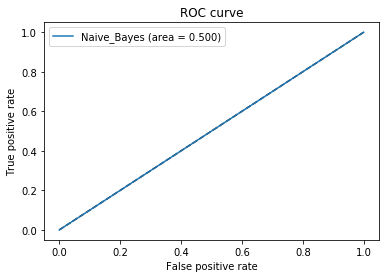

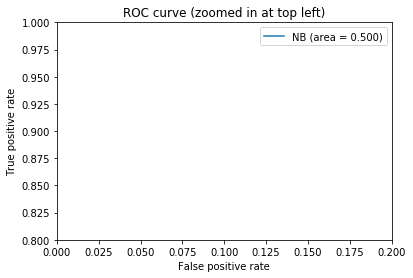

In [2]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Naive_Bayes (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='NB (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()